# 照片 -> 情感 -> 推荐音乐

基本的操作全是复用 recommend-text.ipynb 里面的代码，只是最后从的推荐从

- 文本 => emotext => recommend

改成:

- 图片 => emopic => recommend

In [1]:
# load config

import json

with open('config.json') as f:
    config = json.load(f)

In [2]:
# init db

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

engine = create_engine(config['db'])

Base = automap_base()
Base.prepare(engine, reflect=True)

Track = Base.classes.tracks
Comment = Base.classes.comments
TrackEmotion = Base.classes.track_emotions

session = Session(engine)

In [3]:
# emotion vector

from typing import List
from collections import namedtuple

import emotext

Emotion = namedtuple('Emotion', emotext.emotions)


def keys(self):
    return self._fields


def values(self):
    return tuple(self)


Emotion.keys = keys
Emotion.values = values


def emotion_vector(emotions: List[TrackEmotion]) -> Emotion:
    elems = dict.fromkeys(emotext.emotions, 0)
    elems.update({x.emotion: x.intensity for x in emotions})
    ev = Emotion(**elems)

    return ev

NEW: load model

下面这一步有点新了，不训练模型了，recommend-text.ipynb 里面已经有训练、保存好了。
这里直接取一个模型出来用就行了。

In [4]:
# NEW: load model

import json
import joblib


def load_data_model(data_file, model_file):
    with open(data_file) as df:
        d = json.load(df)
    m = joblib.load(model_file)
    return d, m


data, nbrs = load_data_model('savedata/7597.json', 'savemodels/7597.joblib')

NEW: recommend from picture

类似于 recommend-text.ipynb 的 recommend_from_text，
只是改成输入图片。

In [5]:
from emopic.emotic2emotext import emotic2dlut

import requests

EMOPIC_SERVER = 'http://localhost:8080/infer'


def emotion_from_pic(imgpath: str) -> Emotion:
    """从图片中获取情感。

    请求 emopic/emotic 的 EMOPIC_SERVER 服务，获取给定图片的情感。
    会考虑图片中所有人物 (bbox from yolo)，以图片中人物所占面积比为权重，加权平均。

    :param imgpath: 图片路径
    :return: Emotion 对象
    """
    resp = requests.post(EMOPIC_SERVER, files={
        'img': (imgpath, open(imgpath, 'rb')),
    })
    # [{
    #   "bbox": [65, 15, 190, 186],
    #   "cat": {"Excitement": 0.16, "Peace": 0.11},
    #   "cont": [5.97, 6.06, 7.23]
    # }]
    emotic_result = resp.json()

    # 总的情感
    total_emotion = dict.fromkeys(emotext.emotions, 0.0)

    # 人在图片中占的面积
    area = lambda bbox: (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    areas = [area(p['bbox']) for p in emotic_result]
    sum_area = sum(areas)

    # 转成 emotext 情感，面积大的人权重大
    for person, person_area in zip(emotic_result, areas):
        person_emo = emotic2dlut(person['cat'], person['cont'])
        weight = person_area / sum_area

        for emo, value in person_emo.items():
            total_emotion[emo] += value * weight

    sum_v = sum(v for v in total_emotion.values())
    for k in total_emotion:
        total_emotion[k] /= sum_v

    return Emotion(**total_emotion)


def recommend_from_pic(imgpath: str):
    """给图片，算情感，找近邻，作推荐

    :param imgpath: 推荐种子图片
    :return: (emotion, distances, tracks): 计算得到的 text 情感，和推荐结果：距离与曲目
    """

    # get emotion
    e = emotion_from_pic(imgpath)

    # recommend
    distances, indices = nbrs.kneighbors([e], 10)

    # result tracks
    tracks = []
    for i in range(len(indices[0])):
        idx = indices[0][i]
        tid = data['ids'][idx]
        t = session.query(Track).where(Track.id == tid)[0]
        tracks.append(t)

    return e, distances, tracks


def print_nbrs(distances, tracks):
    for d, t in zip(distances[0], tracks):
        ar = list(map(lambda a: a.name, t.artists_collection))
        print(f'dist={d:.4f}: ({t.id})\t {t.name} - {ar}')


emotion, distances, tracks = recommend_from_pic('/Users/c/Desktop/26.jpg')
print(emotion)
print_nbrs(distances, tracks)

Emotion(PA=0.11634041808839453, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.1087746974602945, NB=0.0922441065005837, NJ=0.08406206226681162, NH=0.0, PF=0.0, NI=0.0, NC=0.04742825954853861, NG=0.0, NE=0.11293075099407504, ND=0.11102636835423838, NN=0.1458165258228255, NK=0.0, NL=0.1402710438773809, PC=0.04110576708685707)
dist=0.2090: (36871866)	 隐形的翅膀 (Live) - ['张韶涵']
dist=0.2270: (451126971)	 Paris - ['Else']
dist=0.2282: (316486)	 野孩子 - ['杨千嬅']
dist=0.2351: (26116350)	 GASSHOW - ['illion']
dist=0.2412: (28923455)	 路 - ['隔壁团乐队']
dist=0.2452: (740765)	 しろつめくさ - ['ハンバート ハンバート']
dist=0.2466: (498371679)	 ι - ['α·Pav']
dist=0.2472: (27888500)	 Turn Down for What - ['Lil Jon', 'DJ Snake']
dist=0.2480: (520460196)	 I always smile but my eyes are sad - ['asokah.']
dist=0.2524: (447079586)	 Look At Me! - ['XXXTENTACION']


In [6]:
emotion, distances, tracks = recommend_from_pic('/Users/c/Desktop/1.jpg')
print(emotion)
print_nbrs(distances, tracks)

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.169806835930514, NI=0.0, NC=0.0, NG=0.0, NE=0.2716199544371121, ND=0.0, NN=0.04285658614709122, NK=0.19077764267738348, NL=0.32493898080789924, PC=0.0)
dist=0.4046: (499673140)	 In The End - ['XXXTENTACION']
dist=0.4086: (405599470)	 疑心病 - ['任然']
dist=0.4112: (5151048)	 New Soul - ['Yael Naim']
dist=0.4129: (30841627)	 接下来如何 - ['Hello Nico']
dist=0.4192: (430114655)	 Astronomia - ['Vicetone', 'Tony Igy']
dist=0.4199: (316451)	 我的回忆不是我的 - ['海鸣威', '泳儿']
dist=0.4246: (165348)	 停止跳动 - ['汪苏泷']
dist=0.4265: (36921285)	 Melody (Original mix) - ['Ash']
dist=0.4295: (27600462)	 Runaway Baby - ['Bruno Mars']
dist=0.4324: (149763)	 毕业后你不是我的 - ['孙子涵']


In [7]:
emotion, distances, tracks = recommend_from_pic('/Users/c/Desktop/21.23.jpg')
print(emotion)
print_nbrs(distances, tracks)

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.15106514434069437, NH=0.0, PF=0.04797134958618257, NI=0.0, NC=0.0, NG=0.0, NE=0.1548680807942048, ND=0.2596078740967889, NN=0.21640554913127888, NK=0.0, NL=0.17008200205085047, PC=0.0)
dist=0.2391: (19934760)	 Leaves in the Wind - ['Isaac Shepard']
dist=0.2498: (418708385)	 ミチノチモシーキミノキモチ - ['森永千才']
dist=0.2646: (139703)	 我想更懂你 - ['潘玮柏', '苏芮']
dist=0.2731: (29009655)	 East of Eden - ['Zella Day']
dist=0.2777: (718551)	 比翼の羽根 - ['eufonius']
dist=0.2808: (477982)	 Old Memory - ['Bruno Wen-li']
dist=0.2822: (17721274)	 Wrecking Ball - ['Frankmusik']
dist=0.2822: (421137966)	 牵丝戏 - ['Aki阿杰', '银临', '大琴师音乐游戏']
dist=0.2863: (407889392)	 LA LA LAND (Extended Mix) - ['DVBBS', 'Shaun Frank', 'Delaney Jane']
dist=0.2906: (412175153)	 φ¹ - ['α·Pav']


🖼 img_file: /Users/c/Desktop/imgs/folklore.jpg


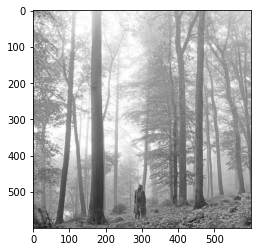

Emotion(PA=0.0, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.6548831146800453, NI=0.0, NC=0.0, NG=0.0, NE=0.092448533048871, ND=0.0, NN=0.15048939952924753, NK=0.0, NL=0.10217895274183608, PC=0.0)
dist=0.2333: (68450)	 小情歌 - ['苏打绿']
dist=0.2426: (375328)	 小情歌 - ['苏打绿']
dist=0.2457: (412911786)	 谎话情歌 - ['好妹妹']
dist=0.2497: (254059)	 情歌 - ['梁静茹']
dist=0.2520: (30148268)	 念念不忘 - ['麦浚龙']
dist=0.2614: (491787693)	 情话 - ['余佳运']
dist=0.2686: (31653813)	 想念自己 - ['陈嘉桦']
dist=0.2730: (209155)	 情歌 - ['陈珊妮']
dist=0.2927: (487923125)	 霸气情歌 - ['陈柏宇']
dist=0.3057: (455304006)	 情歌一首 - ['Kc']
🖼 img_file: /Users/c/Desktop/imgs/BADモード.jpg


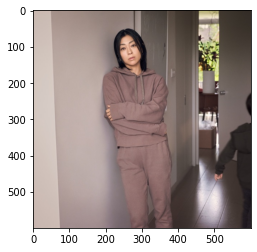

Emotion(PA=0.1342043845909209, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.0, NB=0.0, NJ=0.28043915053033636, NH=0.0, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.21930158938012498, ND=0.08406668719138784, NN=0.042352863417156474, NK=0.0, NL=0.23963532489007341, PC=0.0)
dist=0.3135: (31645164)	 癌 - ['华晨宇']
dist=0.3354: (17405587)	 Still D.R.E. - ['Snoop Dogg', 'Dr. Dre']
dist=0.3496: (454955323)	 时间杀人事件 - ['安全着陆']
dist=0.3540: (525278524)	 无问 - ['毛不易']
dist=0.3548: (27591651)	 Intro AE 86 - ['陈光荣']
dist=0.3618: (518511084)	 Monica - ['The-Beta', 'KEY.L刘聪']
dist=0.3641: (482489340)	 玫瑰 - ['李映川']
dist=0.3651: (525443824)	 ☹ - ['Gray Planet']
dist=0.3658: (399552394)	 Deadwood Main - ['Really Slow Motion']
dist=0.3663: (448547526)	 这份爱（翻自 Davichi）  - ['阿YueYue']
🖼 img_file: /Users/c/Desktop/imgs/evermore.jpg


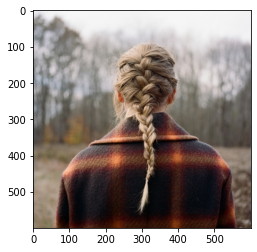

Emotion(PA=0.18721293808298747, PE=0.1157311839210211, PD=0.06976669118989957, PH=0.16487635215369661, PG=0.0, PB=0.2217401601709907, PK=0.0, NA=0.0, NB=0.12362294286391834, NJ=0.0, NH=0.11704973161748618, PF=0.0, NI=0.0, NC=0.0, NG=0.0, NE=0.0, ND=0.0, NN=0.0, NK=0.0, NL=0.0, PC=0.0)
dist=0.1760: (77237)	 驼铃 - ['刀郎']
dist=0.1774: (31134621)	 《瞬间的永恒》夜色钢琴曲 - ['赵海洋']
dist=0.1849: (26609650)	 等我先说 - ['夏天Alex']
dist=0.1852: (28936510)	 星星 - ['牛奶咖啡']
dist=0.1864: (65312)	 明年今日 (2007 Live) - ['陈奕迅']
dist=0.1904: (424995410)	 Homage - ['Mild High Club']
dist=0.1906: (31365604)	 你从未离去 - ['白挺']
dist=0.1920: (108578)	 不流泪的机场 - ['林俊杰']
dist=0.1930: (522320784)	 Ich bin Himmel, wenn ich den Himmel liebe (feat. Seraphina Theresa) - ['Sergio Díaz De Rojas']
dist=0.1932: (478507889)	 卡农（经典钢琴版） - ['dylanf']
🖼 img_file: /Users/c/Desktop/imgs/孩子们-赢-成功-视频游戏-播放-玩耍.jpg


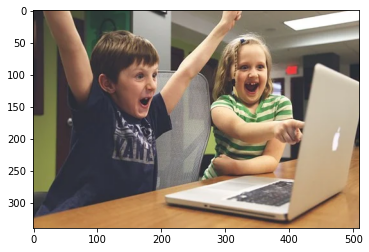

Emotion(PA=0.170639140236208, PE=0.1546323847850401, PD=0.0, PH=0.0, PG=0.0, PB=0.07993212688564175, PK=0.0, NA=0.0, NB=0.0, NJ=0.0, NH=0.0, PF=0.4343650279554316, NI=0.0, NC=0.0, NG=0.0, NE=0.0, ND=0.0, NN=0.0, NK=0.0, NL=0.11524400580228794, PC=0.045187314335390534)
dist=0.2590: (157973)	 思念谁 - ['巫启贤']
dist=0.2654: (31653813)	 想念自己 - ['陈嘉桦']
dist=0.2664: (447279824)	 Rap Beat 2 - ['Gucci Louis']
dist=0.2699: (209155)	 情歌 - ['陈珊妮']
dist=0.2743: (36668711)	 就算我唱遍所有情歌 - ['简弘亦']
dist=0.2791: (287063)	 我怀念的 - ['孙燕姿']
dist=0.2843: (432506367)	 电台情歌 - ['邓超']
dist=0.2894: (255219)	 怎么唱情歌 - ['刘惜君']
dist=0.2900: (256468)	 至少还有你 - ['林忆莲']
dist=0.2920: (455345562)	 守候 - ['赵英俊']
🖼 img_file: /Users/c/Desktop/imgs/男人-老的-高级-苦难-绝望-头痛.jpg


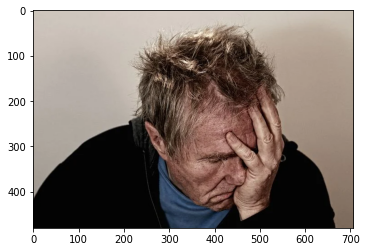

Emotion(PA=0.027128780976985834, PE=0.0, PD=0.0, PH=0.0, PG=0.0, PB=0.0, PK=0.0, NA=0.1517337532641877, NB=0.11411445258577815, NJ=0.0922534834464863, NH=0.0, PF=0.0, NI=0.09442544392236789, NC=0.05032611041572372, NG=0.03918075228849756, NE=0.054817087314605814, ND=0.14010186017126736, NN=0.12149240711740107, NK=0.0, NL=0.07491643763279954, PC=0.03950943086389903)
dist=0.2402: (28586064)	 I'm Not the Only One - ['Sam Smith']
dist=0.2575: (25729599)	 月光奏鸣曲第一乐章 - ['Ludwig van Beethoven']
dist=0.2632: (740765)	 しろつめくさ - ['ハンバート ハンバート']
dist=0.2686: (26116350)	 GASSHOW - ['illion']
dist=0.2748: (26082104)	 Rolling star - ['YUI']
dist=0.2753: (30854130)	 Lean On - ['Major Lazer', 'DJ Snake', 'MØ']
dist=0.2783: (350127)	 你再也读不出我任何欲望 - ['Cicada']
dist=0.2789: (332064)	 相对湿度 - ['郑希怡']
dist=0.2789: (36871866)	 隐形的翅膀 (Live) - ['张韶涵']
dist=0.2793: (454069168)	 ты любил её ?! - ['dalebotbeats']


In [21]:
import os
import matplotlib.pyplot as plt

def _img_recommend(img_file):
    print(f'🖼 img_file: {img_file}')
    im = plt.imread(img_file)
    plt.imshow(im)
    plt.show()

    emotion, distances, tracks = recommend_from_pic(img_file)
    print(emotion)
    print_nbrs(distances, tracks)

for root, dirs, files in os.walk('/Users/c/Desktop/imgs/'):
    for file in files:
        if not file.endswith('jpg'):
            continue
        img = os.path.join(root, file)
        _img_recommend(img)